In [9]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to remove any unnecessory small blobs
def remove_small_contours(rects):
    for i, (x,y,w,h) in enumerate(rects):
        if w*h < 50 :
            rects.pop(i)
    return rects

In [3]:
def label(one_hot_arr):
    labels = '+ - 0 1 2 3 4 5 6 7 8 9 / *'.split()
    index = np.argmax(one_hot_arr)
    return labels[index]

In [10]:
img = cv2.imread("numbers1.jpg")
img = cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# The images in the dataset have white background and black color for the digtis
# However its much more efficient to find contours on an image with BLACK BACKGROUND
# so we threshold the image in both BINARY(black img, white bg) and BINARY_INV(white img, black bg) and
# detect contours on "threshInv" and perform model prediction on "thresh"
_, threshInv = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
_, thresh = cv2.threshold(gray,120, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(threshInv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

preprocessed_digits = []

# Put all the rectangle coordinates of the contours in a list
rects = []
for c in contours:
    rects.append(cv2.boundingRect(c))
    
# remove small blobs if any    
processed_contours = remove_small_contours(rects)
# sort the contours from left to right so that the model predicts the digtis/operators in order
sorted_contours = sorted(processed_contours)

for (x,y,w,h) in sorted_contours:
    cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
    # extract the digit
    digit = thresh[y:y+h, x:x+w]
    # pad some white pixels to the extracted image for better prediction results
    resized_digit = cv2.resize(digit, (26,26), interpolation=cv2.INTER_AREA)
    padded_digit = np.pad(resized_digit, ((3,3),(3,3)), mode='constant', constant_values=255)
    
    preprocessed_digits.append(padded_digit)
    
cv2.imshow("img", img)
cv2.imshow("threshInv", threshInv)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [5]:
model_math = tf.keras.models.load_model("num_detect99.h5")

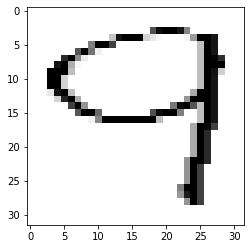

Digit is:  9


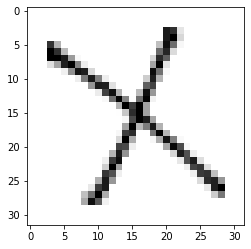

Digit is:  *


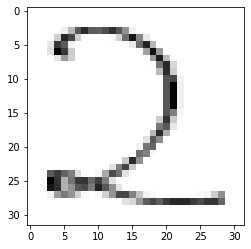

Digit is:  2


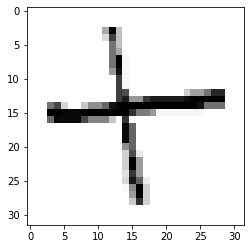

Digit is:  +


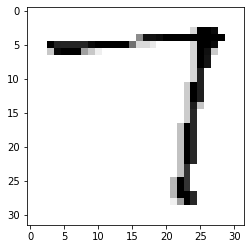

Digit is:  7
Result:  25


In [11]:
res = []
for digit in preprocessed_digits:
    prediction = model_math.predict(digit.reshape(1,32,32,1))
    plt.imshow(digit.reshape(32,32), cmap='gray')
    plt.show()
    print("Digit is: ", label(prediction))
    res.append(label(prediction))
print("Result: ", eval("".join(res)))